# Assignment 1 - YourName

**Filename: Assignment1_YourName.ipynb**

### **Problem 1: What is the average trip distance?**

In [6]:
import pymysql

# Connect to the database
connection = pymysql.connect(host='localhost', user='root', password='root', database='nyc_taxi_data')

try:
    with connection.cursor() as cursor:
        # Execute a query
        cursor.execute("SELECT AVG(trip_distance) FROM nyc_taxi_data.nyctaxidata;")
        
        # Fetch all rows from the last executed query
        result = cursor.fetchall()
        
        for row in result:
            print(float(row[0]))
finally:
    connection.close()


3.303828


### **Problem 2: What is the relationship between trip distance and fare amount?**

#### Method 1: High Limit, load all in memory

In [ ]:
import pymysql

# Connect to the database
connection = pymysql.connect(host='localhost', user='root', password='root', database='nyc_taxi_data')
try:
    # Execute a query and save the result directly into a pandas DataFrame
    df = pd.read_sql_query("SELECT trip_distance, fare_amount FROM nyc_taxi_data.nyctaxidata LIMIT 10000000;", connection)
finally:
    connection.close()

In [82]:
df.head()

,trip_distance,fare_amount
0,1.10,10.0
1,2.20,13.5
2,0.66,7.2
3,2.20,11.4
4,5.70,23.3


#### Method 2: Chunk into smaller pieces

In [86]:
import pymysql

end_df = pd.DataFrame()
chunk_size = 100000
# Connect to the database
connection = pymysql.connect(host='localhost', user='root', password='root', database='nyc_taxi_data')
try:
    for chunk in pd.read_sql_query("SELECT trip_distance, fare_amount FROM nyc_taxi_data.nyctaxidata LIMIT 10000000;",
                                   connection,
                                   chunksize=chunk_size):
        end_df = pd.concat([end_df, chunk], ignore_index = True)
finally:
    connection.close()

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10704\500257598.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  for chunk in pd.read_sql_query("SELECT trip_distance, fare_amount FROM nyc_taxi_data.nyctaxidata LIMIT 10000000;", connection, chunksize=chunk_size):


In [87]:
end_df.head()

,trip_distance,fare_amount
0,1.10,10.0
1,2.20,13.5
2,0.66,7.2
3,2.20,11.4
4,5.70,23.3


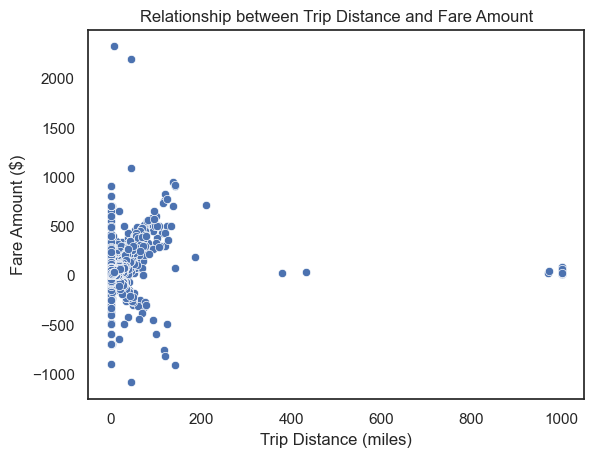

In [73]:
import matplotlib.pyplot as plt

scatter_plot  = sns.scatterplot(x="trip_distance", y="fare_amount", data=df)

scatter_plot.set_title('Relationship between Trip Distance and Fare Amount')
scatter_plot.set_xlabel('Trip Distance (miles)')
scatter_plot.set_ylabel('Fare Amount ($)')
scatter_plot;

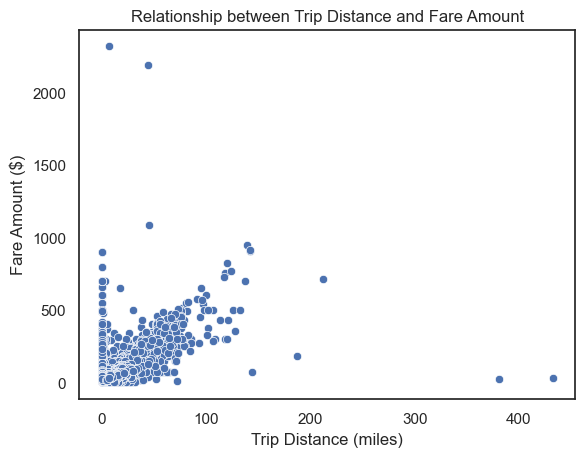

In [74]:
#Interesting to see that there are negative fare_amount values that need to be investigated further. 
## Also, there is an outlier in the data. We will remove it.

scatter_plot  = sns.scatterplot(x="trip_distance", y="fare_amount", data=df[(df['trip_distance']<500) & (df['fare_amount']>0)])

scatter_plot.set_title('Relationship between Trip Distance and Fare Amount')
scatter_plot.set_xlabel('Trip Distance (miles)')
scatter_plot.set_ylabel('Fare Amount ($)')
scatter_plot;

### **Problem 3: What are the busiest hours for taxi trips?**

In [75]:
import pymysql

rides_per_hour = []
# Connect to the database
connection = pymysql.connect(host='localhost', user='root', password='root', database='nyc_taxi_data')

try:
    with connection.cursor() as cursor:
        # Execute a query
        cursor.execute("SELECT EXTRACT(HOUR FROM tpep_pickup_datetime) AS hour, COUNT(*) AS num_trips FROM nyc_taxi_data.nyctaxidata GROUP BY hour ORDER BY num_trips DESC;")
        
        # Fetch all rows from the last executed query
        result = cursor.fetchall()
        
        for row in result:
            rides_per_hour.append(row)
finally:
    connection.close()

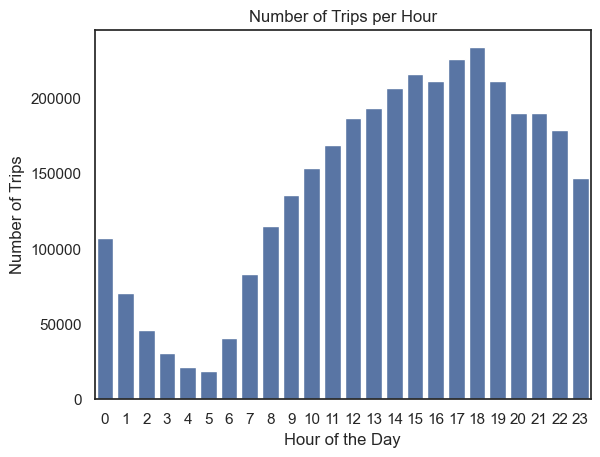

In [76]:
import matplotlib.pyplot as plt

rides_df = pd.DataFrame(rides_per_hour)
rides_df.columns = ['hour','num_trips']
rides_df.sort_values(by = 'hour', ascending = True)

barplot = sns.barplot(x='hour', y='num_trips', data=rides_df)

barplot.set_title('Number of Trips per Hour')
barplot.set_xlabel('Hour of the Day')
barplot.set_ylabel('Number of Trips')
barplot;

### **Problem 4: What is the distribution of total fare amounts?**

In [77]:
df.shape

(3376566, 2)

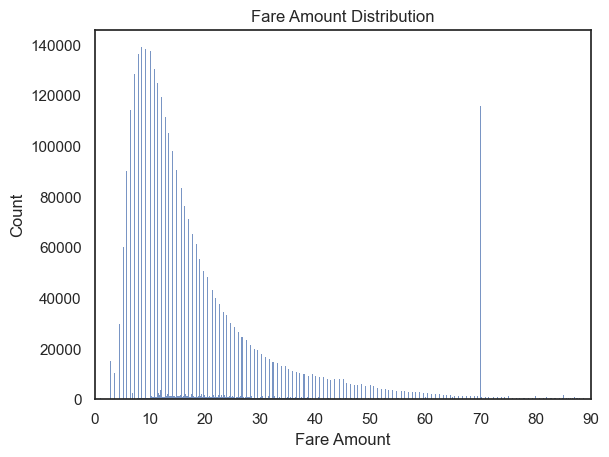

In [90]:
# histogram plot
histogram = sns.histplot(x='fare_amount', data=df[df['fare_amount']>0])

plt.title('Fare Amount Distribution')
plt.xlabel('Fare Amount')  
plt.ylabel('Count')
plt.xlim(0,90)

# Display the plot
plt.show()

### **Problem 5: What is the average trip duration?**

In [1]:
import pymysql

# Connect to the database
connection = pymysql.connect(host='localhost', user='root', password='root', database='nyc_taxi_data')

try:
    with connection.cursor() as cursor:
        # Execute a query
        cursor.execute("SELECT AVG(TIMESTAMPDIFF(MINUTE, tpep_pickup_datetime, tpep_dropoff_datetime)) AS trip_duration_minutes FROM nyc_taxi_data.nyctaxidata LIMIT 100000000")
        
        # Fetch all rows from the last executed query
        result = cursor.fetchall()
        
        for row in result:
            print("avg trip: ",float(row[0]), " minutes")
finally:
    connection.close()


avg trip:  17.6717  minutes


## APPENDIX: Figuring out the spike around $70 in Question 4.

In [96]:
import pymysql

new_df = pd.DataFrame()
chunk_size = 100000

# Connect to the database
connection = pymysql.connect(host='localhost', user='root', password='root', database='nyc_taxi_data')

query = "SELECT *, TIMESTAMPDIFF(MINUTE, tpep_pickup_datetime, tpep_dropoff_datetime) AS trip_duration_minutes FROM nyc_taxi_data.nyctaxidata LIMIT 100000000"

chunks = []

try:
    for chunk in pd.read_sql_query(query, connection, chunksize=chunk_size):
        chunks.append(chunk)
finally:
    connection.close()

new_df = pd.concat(chunks, ignore_index = True)

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10704\1316467031.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  for chunk in pd.read_sql_query(query,


In [101]:
new_df = pd.DataFrame(new_df)

In [102]:
new_df[new_df['fare_amount'] == 70]

,id,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,trip_duration_minutes
82,83,1,2023-12-01 00:07:16,2023-12-01 00:33:42,1.0,18.70,2,N,132,148,...,70.0,2.50,0.5,14.80,0.00,1.0,88.80,2.5,0.00,26
95,96,2,2023-12-01 00:27:23,2023-12-01 00:27:32,1.0,0.01,2,N,264,264,...,70.0,0.00,0.5,0.00,0.00,1.0,71.50,0.0,0.00,0
130,131,2,2023-12-01 00:38:28,2023-12-01 00:38:36,1.0,0.00,2,N,237,237,...,70.0,0.00,0.5,0.00,0.00,1.0,74.00,2.5,0.00,0
368,369,2,2023-12-01 00:27:13,2023-12-01 01:03:30,1.0,16.95,2,N,41,132,...,70.0,0.00,0.5,0.00,6.94,1.0,78.44,0.0,0.00,36
469,470,2,2023-12-01 00:22:34,2023-12-01 00:59:35,1.0,17.90,2,N,132,48,...,70.0,0.00,0.5,0.00,0.00,1.0,75.75,2.5,1.75,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3372241,3372242,1,2023-12-31 17:02:01,2023-12-31 17:35:47,0.0,16.70,0,,132,137,...,70.0,1.75,0.5,12.40,6.94,1.0,95.09,0.0,0.00,33
3373138,3373139,1,2023-12-31 19:24:26,2023-12-31 19:57:07,0.0,17.50,0,,132,141,...,70.0,1.75,0.5,15.15,0.00,1.0,90.90,0.0,0.00,32
3373182,3373183,1,2023-12-31 19:25:59,2023-12-31 19:58:05,0.0,16.40,0,,132,237,...,70.0,1.75,0.5,7.57,0.00,1.0,83.32,0.0,0.00,32
3375562,3375563,1,2023-12-31 22:45:37,2023-12-31 23:20:31,0.0,17.80,0,,132,152,...,70.0,1.75,0.5,12.02,6.94,1.0,92.21,0.0,0.00,34


In [105]:
new_df.columns

Index(['id', 'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee',
       'trip_duration_minutes'],
      dtype='object')

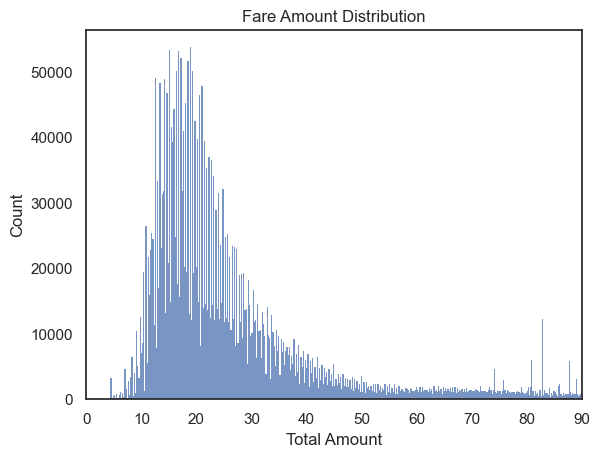

In [108]:
# histogram plot
histogram = sns.histplot(x='total_amount', data=new_df[new_df['fare_amount']>0])

plt.title('Fare Amount Distribution')
plt.xlabel('Total Amount')  
plt.ylabel('Count')
plt.xlim(0,90)

# Display the plot
plt.show()